In [7]:
import glob
import os
from tqdm import tqdm
tqdm.pandas()

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as u

from photutils import morphology

from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import cv2 as cv


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [2]:
im_folder = 'E:/GZ-DESI/images'
data_folder = 'E:/GZ-DESI/data'

In [3]:
major_dist_ims = glob.glob(f'{im_folder}/major-dist/*.fits')

In [4]:
df_paths = pd.DataFrame(major_dist_ims).rename(columns = {0 : 'im_paths'})

In [5]:
df_paths.im_paths.iloc[0]

'E:/GZ-DESI/images/major-dist\\100012_421-cutout.fits'

In [6]:
df_ids = (
    df_paths
    .assign(id_str = df_paths.im_paths.apply(lambda x: os.path.basename(x).replace('-cutout.fits','').replace('gray-','')))
)


### Testing Getting GINI Coefficient

In [8]:
data = fits.getdata(df_paths.im_paths.iloc[0])
header = fits.getheader(df_paths.im_paths.iloc[0])

In [9]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BANDS   = 'grz     '                                                            
BAND0   = 'g       '                                                            
BAND1   = 'r       '                                                            
BAND2   = 'z       '        

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


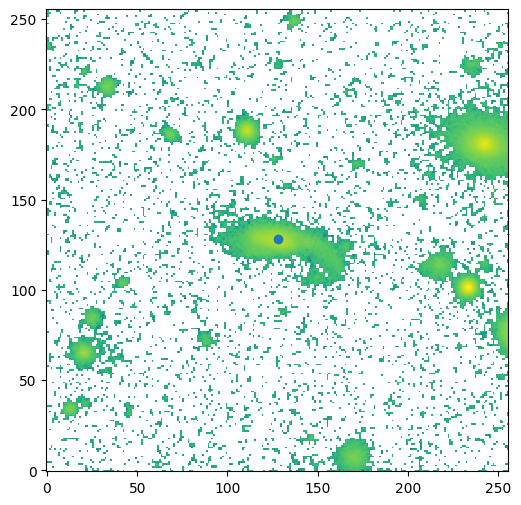

In [10]:
plt.figure(figsize = (6,6))
plt.imshow(np.log10(data[1,:,:]), origin = 'lower')
plt.scatter(data.shape[1]/2, data.shape[2]/2)
plt.show()

Ok, so, issue is that the galaxy is not the center of attention! Need to zoom in on the galaxy.

In [11]:
df = pd.read_parquet(f'{data_folder}/2023-03-15-cats/definitive-merged-interesting-params.parquet', engine = 'pyarrow').query('category == "major_interaction"')

In [12]:
df_ids.id_str.iloc[0]

'100012_421'

In [13]:
row = df.query('id_str == @df_ids.id_str.iloc[0]')

In [14]:
row

,id_str,merging_none_fraction,merging_minor-disturbance_fraction,merging_major-disturbance_fraction,merging_merger_fraction,category,ra,dec,log_l_ha,log_l_oiii,photo_z,spec_z,redshift,redshift_nsa,total_sfr_avg,elpetro_mass,logMH,elpetro_mass_log,log_m_bh,log_bolometric_l
76577,100012_421,0.222982,0.20657,0.527956,0.042492,major_interaction,36.303316,-44.348649,NaN,NaN,0.270214,NaN,0.270214,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting the Petrosian Radius

In [15]:
df_all_data = pd.read_parquet(f'{data_folder}/2023-03-15-cats/int-predicted-catmerged.parquet', engine = 'pyarrow')

In [16]:
df_red = df_all_data[['id_str','ra','dec','petro_theta','est_petro_th50', 'petro_th50', 'petro_th90']]

In [17]:
df_merged = df_ids.merge(df_red, on = 'id_str', how = 'left')

### Creating a Pipeline

In [18]:
df_merged

,im_paths,id_str,ra,dec,petro_theta,est_petro_th50,petro_th50,petro_th90
0,E:/GZ-DESI/images/major-dist\100012_421-cutout...,100012_421,36.303316,-44.348649,NaN,2.393999,NaN,NaN
1,E:/GZ-DESI/images/major-dist\100025_3459-cutou...,100025_3459,40.747850,-44.142658,NaN,2.026541,NaN,NaN
2,E:/GZ-DESI/images/major-dist\100049_651-cutout...,100049_651,49.191266,-44.344255,NaN,2.382727,NaN,NaN
3,E:/GZ-DESI/images/major-dist\100061_265-cutout...,100061_265,53.409491,-44.357158,NaN,2.103341,NaN,NaN
4,E:/GZ-DESI/images/major-dist\100108_3617-cutou...,100108_3617,69.833979,-44.193233,NaN,3.622461,NaN,NaN
...,...,...,...,...,...,...,...,...
11589,E:/GZ-DESI/images/major-dist\99801_4400-cutout...,99801_4400,322.647672,-44.436758,NaN,9.058787,NaN,NaN
11590,E:/GZ-DESI/images/major-dist\99836_4996-cutout...,99836_4996,335.028729,-44.457437,NaN,2.841919,NaN,NaN
11591,E:/GZ-DESI/images/major-dist\99850_3747-cutout...,99850_3747,339.845061,-44.488863,NaN,2.081201,NaN,NaN
11592,E:/GZ-DESI/images/major-dist\99857_2264-cutout...,99857_2264,342.304118,-44.498664,NaN,2.840653,NaN,NaN


In [19]:
petro_50 = df_merged.est_petro_th50.iloc[0]
path = df_merged.im_paths.iloc[0]
ra = df_merged.ra.iloc[0]
dec = df_merged.dec.iloc[0]

In [20]:
WCS(header, naxis=2)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 36.3033161903047  -44.3486493310395  
CRPIX : 128.5  128.5  
CD1_1 CD1_2  : -7.27777777777778e-05  0.0  
CD2_1 CD2_2  : 0.0  7.27777777777778e-05  
NAXIS : 256  256  3

In [21]:
data = fits.getdata(path)
header = fits.getheader(path)

w = WCS(header, naxis = 2)

size = u.Quantity((4*petro_50, 4*petro_50), u.arcsec)
coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
cutout = Cutout2D(data[1,:,:], coord, size, wcs = w)

naive_gini = morphology.gini(cutout.data)
naive_gini

0.7091522489526041

### Applying Contours

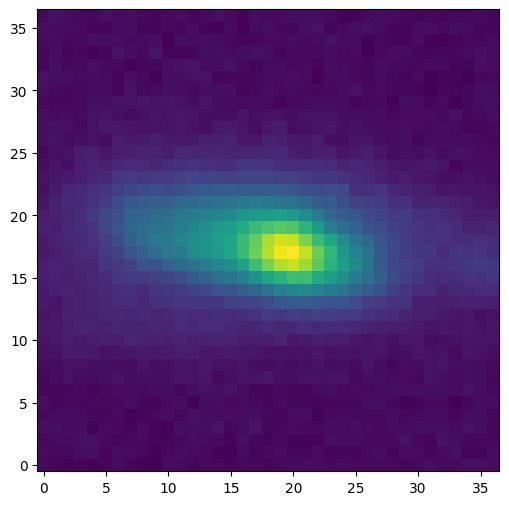

In [22]:
plt.figure(figsize = (6,6))
plt.imshow(cutout.data, origin = 'lower')
plt.show()

In [23]:
cutout.data

array([[ 7.5584612e-05, -6.3136069e-04, -3.4179220e-03, ...,
         5.2425880e-03,  5.1636053e-03,  2.9419772e-03],
       [ 2.1645781e-03,  9.5251866e-04,  4.4667465e-04, ...,
        -1.1758152e-03, -1.7526959e-03,  2.4610392e-03],
       [ 2.1426202e-04,  1.9022371e-03,  1.5426598e-03, ...,
        -3.3985273e-04, -5.8222045e-05,  1.1115659e-04],
       ...,
       [ 2.1761972e-03,  3.6768110e-03,  8.7607950e-06, ...,
         7.2893966e-04, -5.0113711e-04,  1.8268323e-03],
       [ 4.1514207e-03,  2.6667698e-03,  1.9051143e-03, ...,
         2.7322618e-03, -1.5149271e-03, -8.7257399e-04],
       [-2.2096450e-04,  5.4741227e-03,  2.5216131e-03, ...,
         7.8042176e-05,  2.0734889e-03, -1.8154822e-03]], dtype=float32)

In [24]:
cutout_int = cutout.data.copy()
cut = np.percentile(cutout.data,65)
cutout_int[cutout_int <= cut] = 0
cutout_int[cutout_int > cut] = 1
cutout_int = cutout_int.astype(int)

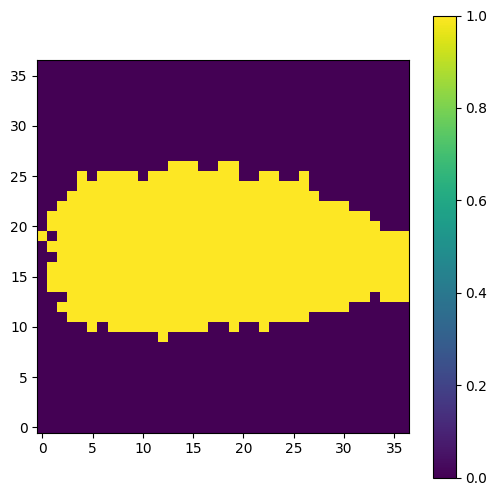

In [25]:
plt.figure(figsize = (6,6))
plt.imshow(cutout_int, origin = 'lower')
plt.colorbar()
plt.show()

In [26]:
contours, _ = cv.findContours(cutout_int, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

In [27]:
def getting_correct_contours(contours):
    length = 0
        
    for i in contours:
        if len(i) > length:
            correct_contours = i
            length = len(i)
    
    return correct_contours

In [28]:
contours_nested_list = getting_correct_contours(contours)

In [29]:
def conts_to_list(contours):
    contour_list = []
    for i in range(len(contours)):
        row = contours[i][0]
        contour_list.append([row[0], row[1]])
    return contour_list

In [30]:
extracted_contour_list = conts_to_list(contours_nested_list)

In [31]:
contour_arr = np.zeros([len(extracted_contour_list),2])
for i in range(len(extracted_contour_list)):
    contour_arr[i,0] = extracted_contour_list[i][0]
    contour_arr[i,1] = extracted_contour_list[i][1]

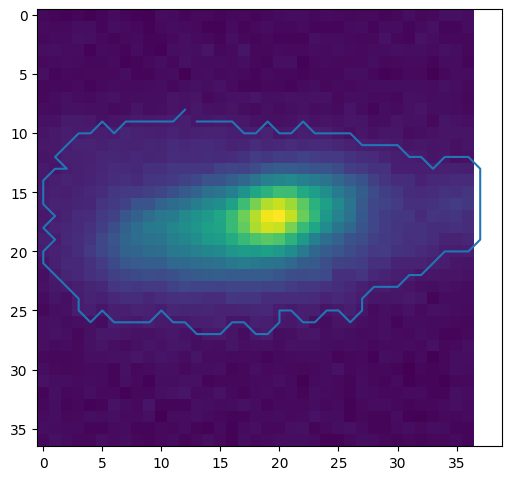

In [32]:
plt.figure(figsize = (6,6))
plt.imshow(cutout.data)
plt.plot(contour_arr[:,0], contour_arr[:,1])
plt.show()

In [33]:
pl = Polygon(contour_arr)

In [34]:
pixels_mask = np.zeros(cutout.data.shape).astype(bool)
for i in range(cutout.data.shape[0]):
    for j in range(cutout.data.shape[1]):
        pt = Point(i,j)
        if pl.contains(pt):
            pixels_mask[i,j] = True
pixels_mask = pixels_mask.T

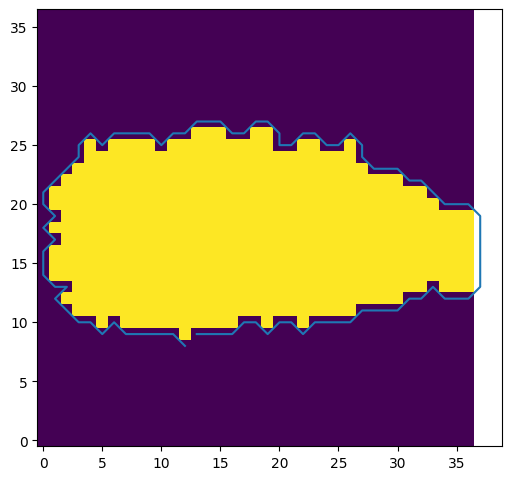

In [35]:
test_im = np.zeros(cutout.data.shape)
test_im[pixels_mask] = 1
plt.figure(figsize = (6,6))
plt.imshow(test_im, origin = 'lower')
plt.plot(contour_arr[:,0], contour_arr[:,1])
plt.show()

In [36]:
reduced_cutout = cutout.data[pixels_mask]

In [37]:
official_gini = morphology.gini(reduced_cutout)
official_gini

0.41877005570873455

### Using a Pipeline

In [38]:
def getting_correct_contours(contours):
    length = 0
        
    for i in contours:
        if len(i) > length:
            correct_contours = i
            length = len(i)
    
    return correct_contours

In [39]:
def conts_to_list(contours):
    contour_list = []
    for i in range(len(contours)):
        row = contours[i][0]
        contour_list.append([row[0], row[1]])
    return contour_list

In [40]:
def get_galaxy(cutout):
    cutout_int = cutout.data.copy()
    
    cut = np.percentile(cutout.data,65)
    cutout_int[cutout_int <= cut] = 0
    cutout_int[cutout_int > cut] = 1
    cutout_int = cutout_int.astype(int)
    
    contours, _ = cv.findContours(cutout_int, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)
    
    contours_nested_list = getting_correct_contours(contours)
    
    extracted_contour_list = conts_to_list(contours_nested_list)
    
    contour_arr = np.zeros([len(extracted_contour_list),2])
    for i in range(len(extracted_contour_list)):
        contour_arr[i,0] = extracted_contour_list[i][0]
        contour_arr[i,1] = extracted_contour_list[i][1]
        
    pl = Polygon(contour_arr)
    
    pixels_mask = np.zeros(cutout.data.shape).astype(bool)
    for i in range(cutout.data.shape[0]):
        for j in range(cutout.data.shape[1]):
            pt = Point(i,j)
            if pl.contains(pt):
                pixels_mask[i,j] = True
    pixels_mask = pixels_mask.T
    
    reduced_cutout = cutout.data[pixels_mask]
    
    return reduced_cutout

In [41]:
def calc_gini_r(path, petro_50, ra, dec):
    
    if np.isnan(petro_50):
        return 'Failed'
    
    data = fits.getdata(path)
    header = fits.getheader(path)
    
    w = WCS(header, naxis = 2)
    
    size = u.Quantity((4*petro_50, 4*petro_50), u.arcsec)
    coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
    try:
        cutout = Cutout2D(data[1,:,:], coord, size, wcs = w, mode='strict')
    except:
        return 'partial-overlap'
    
    if np.sum(cutout.data) == 0:
        return 'empty-image'
    
    reduced_cutout = get_galaxy(cutout)
    
    gini = morphology.gini(reduced_cutout)
    
    return gini

In [47]:
df_ginis = (
    df_merged
    .assign(gini = df_merged.progress_apply(lambda row: calc_gini_r(row.im_paths, row.est_petro_th50, row.ra, row.dec), axis = 1))
)

100%|██████████| 11594/11594 [1:20:59<00:00,  2.39it/s] 


In [ ]:
df_ginis.gini.iloc[0]

In [60]:
len(df_ginis)

11594

In [62]:
df_ginis.gini.value_counts()

partial-overlap        3
empty-image            2
0.41877005570873455    1
0.4839211860208716     1
0.34318451344519285    1
                      ..
0.3171104304219192     1
0.35970000281268655    1
0.3372468555458676     1
0.2868694428068152     1
0.26445911639361885    1
Name: gini, Length: 11591, dtype: int64

In [51]:
# df_export = df_ginis.assign(category = 'major')
# df_export.to_csv(r'C:\Users\oryan\Documents\galaxy-zoo-desi\results/ginis-major.csv')

In [42]:
df_ginis = pd.read_csv(r'C:\Users\oryan\Documents\galaxy-zoo-desi\results/ginis-major.csv', index_col = 0)

### Quick Sanity Checks

In [43]:
df_part_rem = df_ginis.query('gini != "partial-overlap"')
df_rem = df_part_rem.query('gini != "empty-image"')

In [44]:
ginis = np.asarray(list(df_rem.gini)).astype(float)

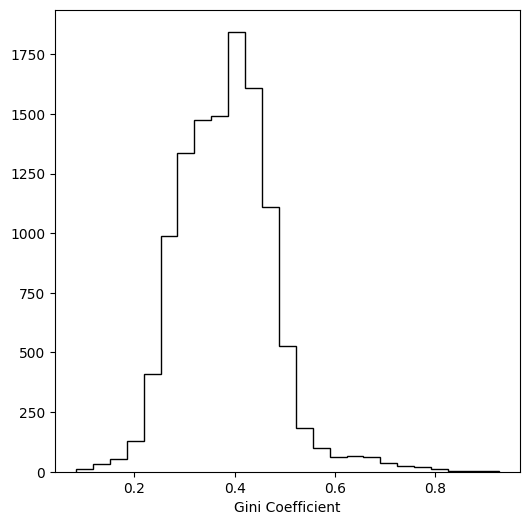

In [45]:
plt.figure(figsize = (6,6))
plt.hist(ginis, bins = 25, color='black', histtype='step')
plt.xlabel('Gini Coefficient')
plt.show()

Next step in sanity checks will be to get a subset of the non-interacting votes and see what these look like!

In [46]:
df_int = df_rem.assign(gini_int = df_rem.gini.apply(lambda x: float(x)))

In [47]:
len(df_int.query('gini_int > 0.85'))

5

In [48]:
weird_data = fits.getdata(df_int.query('gini_int > 0.85').im_paths.iloc[0])

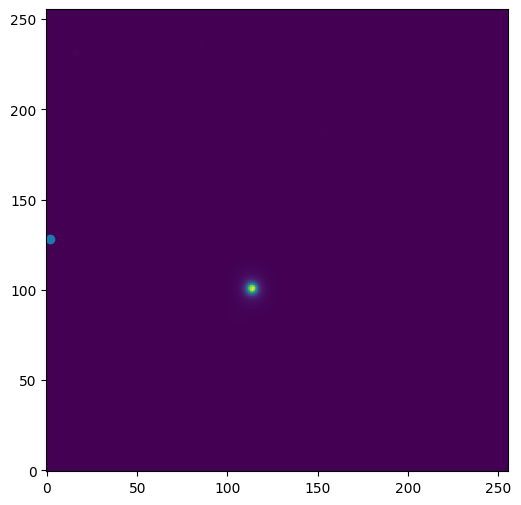

In [49]:
plt.figure(figsize = (6,6))
plt.imshow(weird_data[1,:,:], origin = 'lower')
plt.scatter(weird_data.shape[0]/2, weird_data.shape[1]/2)
plt.show()

### Examining Weird Results

In [50]:
row = df_int.query('gini_int > 0.85').iloc[4]

path = row.im_paths
petro_50 = row.est_petro_th50
ra = row.ra
dec = row.dec

if np.isnan(petro_50):
    print('Failed')
    sys.exit()

data = fits.getdata(path)
header = fits.getheader(path)

w = WCS(header, naxis = 2)

size = u.Quantity((4*petro_50, 4*petro_50), u.arcsec)
coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
try:
    cutout = Cutout2D(data[1,:,:], coord, size, wcs = w, mode='strict')
except:
    print('partial-overlap')
    sys.exit()

if np.sum(cutout.data) == 0:
    print('empty-image')
    sys.exit()

cutout_int = cutout.data.copy()

cut = np.percentile(cutout.data,65)
cutout_int[cutout_int <= cut] = 0
cutout_int[cutout_int > cut] = 1
cutout_int = cutout_int.astype(int)

contours, _ = cv.findContours(cutout_int, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

contours_nested_list = getting_correct_contours(contours)

extracted_contour_list = conts_to_list(contours_nested_list)

contour_arr = np.zeros([len(extracted_contour_list),2])
for i in range(len(extracted_contour_list)):
    contour_arr[i,0] = extracted_contour_list[i][0]
    contour_arr[i,1] = extracted_contour_list[i][1]

pl = Polygon(contour_arr)

pixels_mask = np.zeros(cutout.data.shape).astype(bool)
for i in range(cutout.data.shape[0]):
    for j in range(cutout.data.shape[1]):
        pt = Point(i,j)
        if pl.contains(pt):
            pixels_mask[i,j] = True
pixels_mask = pixels_mask.T

reduced_cutout = cutout.data[pixels_mask]

In [51]:
print(row.gini_int)

0.9260523604214665


C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


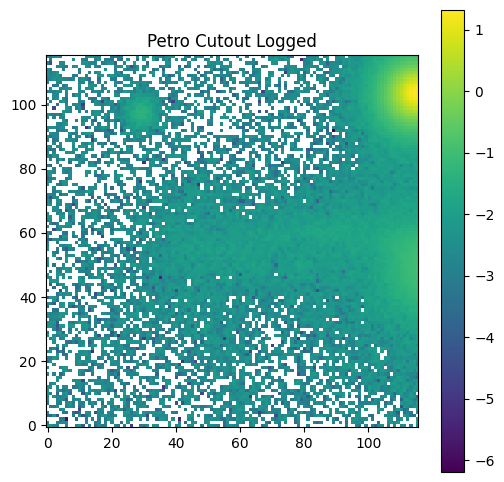

In [52]:
plt.figure(figsize = (6,6))
plt.imshow(np.log10(cutout.data), origin = 'lower')
plt.colorbar()
plt.title('Petro Cutout Logged')
plt.show()

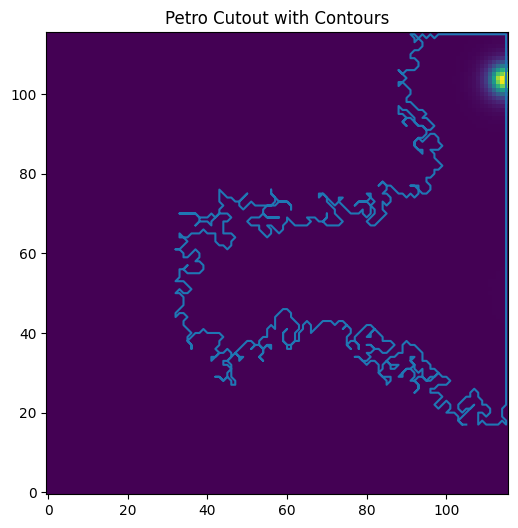

In [53]:
plt.figure(figsize = (6,6))
plt.imshow(cutout.data, origin = 'lower')
plt.plot(contour_arr[:,0], contour_arr[:,1])
plt.title('Petro Cutout with Contours')
plt.show()

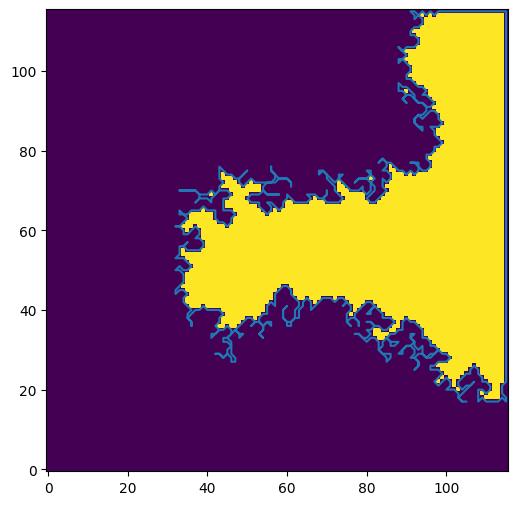

In [54]:
test_im = np.zeros(cutout.data.shape)
test_im[pixels_mask] = 1
plt.figure(figsize = (6,6))
plt.imshow(test_im, origin = 'lower')
plt.plot(contour_arr[:,0], contour_arr[:,1])
plt.show()

Further food for thought.

### Calculating M20

#### Testing a Pipline

In [95]:
row = df_int.iloc[0]

path = row.im_paths
petro_50 = row.est_petro_th50
ra = row.ra
dec = row.dec

In [96]:
if np.isnan(petro_50):
    print('Failed')
    sys.exit()

data = fits.getdata(path)
header = fits.getheader(path)

w = WCS(header, naxis = 2)

size = u.Quantity((4*petro_50, 4*petro_50), u.arcsec)
coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
try:
    cutout = Cutout2D(data[1,:,:], coord, size, wcs = w, mode='strict')
except:
    print('partial-overlap')
    sys.exit()

if np.sum(cutout.data) == 0:
    print('empty-image')
    sys.exit()

cutout_int = cutout.data.copy()

cut = np.percentile(cutout.data,65)
cutout_int[cutout_int <= cut] = 0
cutout_int[cutout_int > cut] = 1
cutout_int = cutout_int.astype(int)

contours, _ = cv.findContours(cutout_int, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

contours_nested_list = getting_correct_contours(contours)

extracted_contour_list = conts_to_list(contours_nested_list)

contour_arr = np.zeros([len(extracted_contour_list),2])
for i in range(len(extracted_contour_list)):
    contour_arr[i,0] = extracted_contour_list[i][0]
    contour_arr[i,1] = extracted_contour_list[i][1]

pl = Polygon(contour_arr)

pixels_mask = np.zeros(cutout.data.shape).astype(bool)
for i in range(cutout.data.shape[0]):
    for j in range(cutout.data.shape[1]):
        pt = Point(i,j)
        if pl.contains(pt):
            pixels_mask[i,j] = True
pixels_mask = pixels_mask.T

In [98]:
mtot = np.inf
for i in range(cutout.shape[0]):
    for j in range(cutout.shape[1]):
        
        if not pixels_mask[i,j]:
            continue
        
        m_tmp = 0
        
        for p in range(cutout.shape[0]):
            for q in range(cutout.shape[1]):
                
                if not pixels_mask[i,j]:
                    continue
                
                m_tmp += cutout.data[p,q] * ((p - i)**2 + (q - j)**2)
                
        if m_tmp < mtot:
            mtot = m_tmp.copy()
            center = [i,j]

In [101]:
f_tot = np.sum(cutout.data[pixels_mask])

In [108]:
sum_f = 0
cutout_array = cutout.data.copy()
cutout_array[np.invert(pixels_mask)] = 0
pixels = []

while sum_f < 0.20 * f_tot:
    arr_max = np.max(cutout_array)
    indices = np.where(cutout_array == arr_max)
    x = indices[0][0]
    y = indices[1][0]
    
    pixels.append([x,y])
    
    sum_f += arr_max
    cutout_array[x,y] = 0

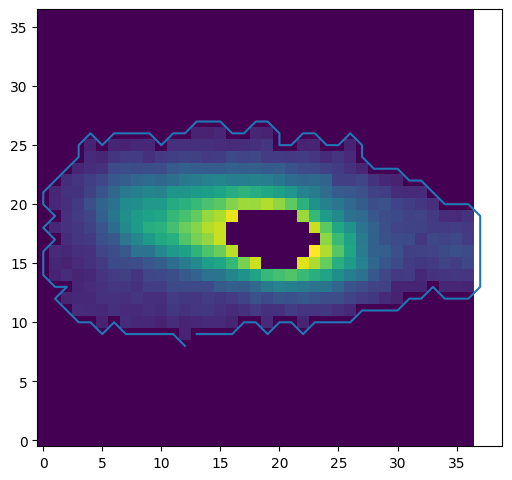

In [ ]:
plt.figure(figsize = (6,6))
plt.imshow(cutout_array, origin = 'lower')
plt.plot(contour_arr[:,0], contour_arr[:,1])
plt.show()

In [111]:
m_i = []
for i in pixels:
    x = i[0]
    y = i[1]
    f = cutout.data[x,y]
    
    m_i.append(f * ((x - center[0])**2 + (y - center[1])**2))

In [112]:
m_20 = np.log10(np.sum(m_i) / mtot)

In [113]:
m_20

-1.7854190656864921

### An M20 Pipeline

In [12]:
def calc_m20(row):
    
    path = row.im_paths
    petro_50 = row.est_petro_th50
    ra = row.ra
    dec = row.dec
    
    if np.isnan(petro_50):
         return 'Failed'
        

    data = fits.getdata(path)
    header = fits.getheader(path)

    w = WCS(header, naxis = 2)

    size = u.Quantity((4*petro_50, 4*petro_50), u.arcsec)
    coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
    try:
        cutout = Cutout2D(data[1,:,:], coord, size, wcs = w, mode='strict')
    except:
        return 'partial-overlap'

    if np.sum(cutout.data) == 0:
        return 'empty-image'

    cutout_int = cutout.data.copy()

    cut = np.percentile(cutout.data,65)
    cutout_int[cutout_int <= cut] = 0
    cutout_int[cutout_int > cut] = 1
    cutout_int = cutout_int.astype(int)

    contours, _ = cv.findContours(cutout_int, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

    contours_nested_list = getting_correct_contours(contours)

    extracted_contour_list = conts_to_list(contours_nested_list)

    contour_arr = np.zeros([len(extracted_contour_list),2])
    for i in range(len(extracted_contour_list)):
        contour_arr[i,0] = extracted_contour_list[i][0]
        contour_arr[i,1] = extracted_contour_list[i][1]

    pl = Polygon(contour_arr)

    pixels_mask = np.zeros(cutout.data.shape).astype(bool)
    for i in range(cutout.data.shape[0]):
        for j in range(cutout.data.shape[1]):
            pt = Point(i,j)
            if pl.contains(pt):
                pixels_mask[i,j] = True
    pixels_mask = pixels_mask.T
    
    mtot = np.inf
    for i in range(cutout.shape[0]):
        for j in range(cutout.shape[1]):

            if not pixels_mask[i,j]:
                continue

            m_tmp = 0

            for p in range(cutout.shape[0]):
                for q in range(cutout.shape[1]):

                    if not pixels_mask[i,j]:
                        continue

                    m_tmp += cutout.data[p,q] * ((p - i)**2 + (q - j)**2)

            if m_tmp < mtot:
                mtot = m_tmp.copy()
                center = [i,j]

    f_tot = np.sum(cutout.data[pixels_mask])
    
    sum_f = 0
    cutout_array = cutout.data.copy()
    pixels = []

    sum_f = 0
    cutout_array = cutout.data.copy()
    cutout_array[np.invert(pixels_mask)] = 0
    pixels = []

    while sum_f < 0.20 * f_tot:
        arr_max = np.max(cutout_array)
        indices = np.where(cutout_array == arr_max)
        x = indices[0][0]
        y = indices[1][0]

        pixels.append([x,y])

        sum_f += arr_max
        cutout_array[x,y] = 0
        
    m_i = []
    for i in pixels:
        x = i[0]
        y = i[1]
        f = cutout.data[x,y]

        m_i.append(f * ((x - center[0])**2 + (y - center[1])**2))
        
    m_20 = np.log10(np.sum(m_i) / mtot)
    
    return m_20

In [28]:
ProgressBar().register()

In [20]:
ddf = dd.from_pandas(df_int[:10], npartitions = 4)

In [24]:
def m20_wrapper(df):
    return df.apply(calc_m20, axis = 1)

In [46]:
pd.Series(None,dtype = float)

Series([], dtype: float64)

In [47]:
dask_series = ddf.apply(calc_m20, axis=1, meta = pd.Series(None, dtype=float))

In [48]:
dask_series.compute()

[########################################] | 100% Completed |  1min 34.4s


0   -1.785419
1   -2.081229
2   -2.284182
3   -2.238069
4   -2.007765
5   -1.805031
6   -1.760063
7   -2.593506
8   -1.918205
9   -1.911381
dtype: float64

In [56]:
df_tmp = df_int[:10]
df_tmp['m20'] = dask_series.compute()

[########################################] | 100% Completed |  1min 35.3s


In [57]:
df_tmp

,im_paths,id_str,ra,dec,petro_theta,est_petro_th50,petro_th50,petro_th90,gini,category,gini_int,m20
0,E:/GZ-DESI/images/major-dist\100012_421-cutout...,100012_421,36.303316,-44.348649,NaN,2.393999,NaN,NaN,0.41877005570873455,major,0.418770,-1.785419
1,E:/GZ-DESI/images/major-dist\100025_3459-cutou...,100025_3459,40.747850,-44.142658,NaN,2.026541,NaN,NaN,0.47764445919663906,major,0.477644,-2.081229
2,E:/GZ-DESI/images/major-dist\100049_651-cutout...,100049_651,49.191266,-44.344255,NaN,2.382727,NaN,NaN,0.46975089652240526,major,0.469751,-2.284182
3,E:/GZ-DESI/images/major-dist\100061_265-cutout...,100061_265,53.409491,-44.357158,NaN,2.103341,NaN,NaN,0.4185728701900139,major,0.418573,-2.238069
4,E:/GZ-DESI/images/major-dist\100108_3617-cutou...,100108_3617,69.833979,-44.193233,NaN,3.622461,NaN,NaN,0.2901572380610142,major,0.290157,-2.007765
5,E:/GZ-DESI/images/major-dist\100121_1480-cutou...,100121_1480,74.199292,-44.294576,NaN,3.845420,NaN,NaN,0.4380188933001363,major,0.438019,-1.805031
6,E:/GZ-DESI/images/major-dist\100137_317-cutout...,100137_317,80.027603,-44.360286,NaN,2.869212,NaN,NaN,0.48126776103897406,major,0.481268,-1.760063
7,E:/GZ-DESI/images/major-dist\100144_696-cutout...,100144_696,82.387188,-44.339010,NaN,4.958794,NaN,NaN,0.49315164246023685,major,0.493152,-2.593506
8,E:/GZ-DESI/images/major-dist\100784_196-cutout...,100784_196,305.167995,-44.364778,NaN,2.161971,NaN,NaN,0.2364782634126245,major,0.236478,-1.918205
9,E:/GZ-DESI/images/major-dist\100791_5616-cutou...,100791_5616,307.720477,-44.179044,NaN,2.226155,NaN,NaN,0.25410384103944805,major,0.254104,-1.911381


In [55]:
df_m20 = (
    df_int[:10]
    .assign(m20 = df_int[:10].progress_apply(lambda row: calc_m20(row), axis = 1))
    .drop(columns = ['gini'])
    .rename(columns = {'gini_int' : 'gini'})
)

100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


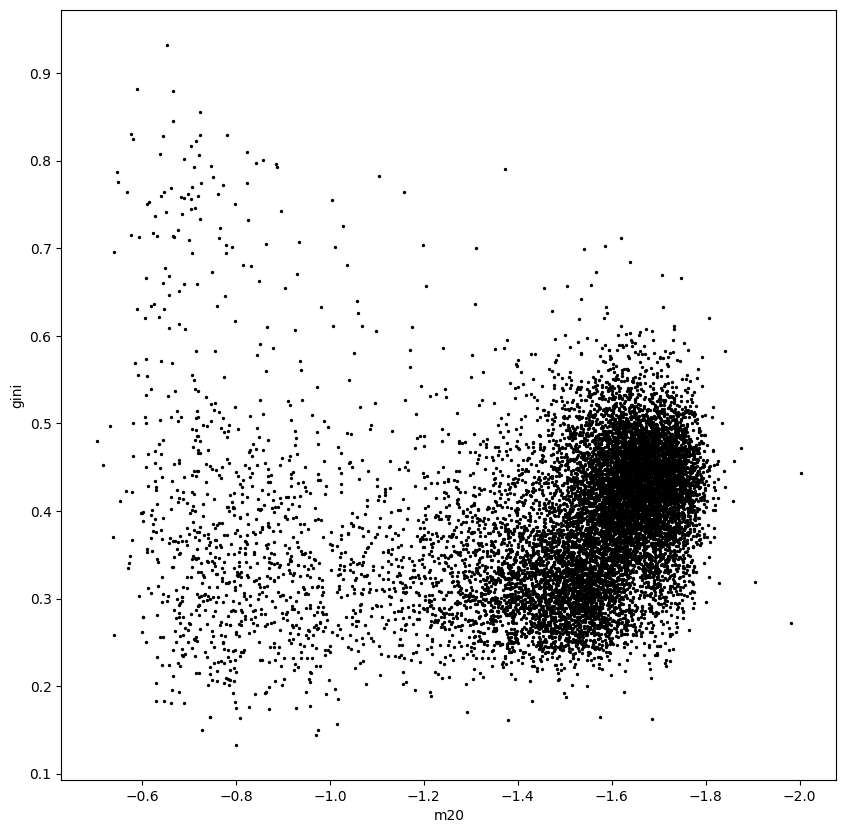

In [55]:
df_m20.plot.scatter(
    x = 'm20',
    y = 'gini',
    s = 2,
    color = 'black',
    figsize = (10,10)   
)
plt.gca().invert_xaxis()